In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import cvxpy as cp
from sklearn.covariance import LedoitWolf
from tqdm import tqdm

In [ ]:
Static = pd.read_excel("https://raw.githubusercontent.com/youli99/S-E-Finance/main/Data_new/Static.xlsx")

# EScore = pd.read_excel("./Data/DS_EScore_Y.xlsx")
# SScore = pd.read_excel("./Data/DS_SScore_Y.xlsx")
GScore = pd.read_excel("https://raw.githubusercontent.com/youli99/S-E-Finance/main/Data_new/DS_GScore_Y.xlsx")
# ESGScore = pd.read_excel("./Data/DS_ESGScore_Y.xlsx")

RI_m = pd.read_excel("https://raw.githubusercontent.com/youli99/S-E-Finance/main/Data_new/DS_RI_USD_M.xlsx").iloc[:, :-1]
# RI_y = pd.read_excel("./Data/DS_RI_USD_Y.xlsx")
MC_m = pd.read_excel("https://raw.githubusercontent.com/youli99/S-E-Finance/main/Data_new/DS_MV_USD_M.xlsx").iloc[:, :-1]
# MC_y = pd.read_excel("./Data/DS_MV_USD_Y.xlsx")
# REV_y = pd.read_excel("./Data_new/DS_REV_USD_Y.xlsx")

# Scope1 = pd.read_excel("./Data/Scope_1.xlsx")
# Scope2 = pd.read_excel("./Data/Scope_2.xlsx")


In [ ]:
time = RI_m.iloc[:, 3:].columns # extract the timestamp index
RF_m = pd.read_excel("https://raw.githubusercontent.com/youli99/S-E-Finance/main/Data_new/Risk_Free_Rate.xlsx", index_col=0)

RF_m = RF_m / 100
RF_m.index = time
RF_m = RF_m.T
RF_m.reset_index(drop=True, inplace=True)

#extract 2014-2024
RF_m_temp_original = RF_m.loc[:, (RF_m.columns >= pd.Timestamp("2014-01-01")) & (RF_m.columns <= pd.Timestamp("2024-12-31"))]
RF_m_temp = RF_m_temp_original.T

In [4]:
# Filter the firms:
# Condition 1: Europe
# Condition 2: GScore data avaiable
GScore_merged = GScore.merge(Static, on="ISIN")
GScore_eur = GScore_merged.loc[GScore_merged["Region"] == "EUR"].copy()
# GScore_eur.dropna(subset=[GScore_eur.columns[x] for x in range(16, 27)], inplace=True)

In [6]:
# Our dataset of group7
RI_m_eur = RI_m.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")
# RI_y_eur = RI_y.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")
MC_m_eur = MC_m.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")
# MC_y_eur = MC_y.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")
# REV_y_eur = REV_y.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")

# Data Cleaning


##### Clean RI_m_eur

In [7]:
# calculate the returns
temp = RI_m_eur.iloc[:, 2:].diff(axis=1) / RI_m_eur.iloc[:,2:].shift(axis=1)
# dropna if with continuously more than 12 NA
# mask = temp.isna().rolling(window=12, axis=1).agg(sum).max(axis=1) >= 12
# temp = temp[~mask]

R_m = pd.concat([RI_m_eur[["NAME", "ISIN"]], temp], axis=1)

In [8]:
# Check if there are outliers in the data
((temp > 100) | (temp < -100)).sum().sum()

6

In [ ]:
# replace the outliers with the average of the previous and next value
def replace_outliers(df):
    df_filled = df.copy()
    for index, row in df_filled.iterrows():
        outliers = (row < -100) | (row > 100)
        df_filled.loc[index, outliers] = (row.shift()[outliers] + row.shift(-1)[outliers]) / 2
    return df_filled

temp2 = replace_outliers(temp)

In [10]:
((temp2 > 100) | (temp2 < -100)).sum().sum()

0

In [11]:
# fill NaN at the beginning/end with the average over the avaiable sample
def fill_na(df):
     df_filled = df.copy()
     for index, row in df_filled.iterrows():
          available_mean = row.dropna().mean()
          first_valid = row.index.get_loc(row.first_valid_index())
          last_valid = row.index.get_loc(row.last_valid_index()) # find the NaN at the beginning/end
          if first_valid != 0:
               df_filled.iloc[index, :first_valid] = available_mean
          if last_valid != len(row) - 1:
               df_filled.iloc[index, last_valid + 1:] = available_mean
     return df_filled

temp2 = fill_na(temp2)

In [12]:
# Linear interpolation for the missing value at the middle
temp2 = temp2.interpolate(method="linear" ,axis=1)

In [13]:
# extract 2014-2024
temp3 = temp2.loc[:, (temp2.columns >= pd.Timestamp("2014-01-01")) & (temp2.columns <= pd.Timestamp("2024-12-31"))].copy()

# extract 2004-2024
temp0424 = temp2.loc[:, (temp2.columns >= pd.Timestamp("2004-01-01")) & (temp2.columns <= pd.Timestamp("2024-12-31"))].copy()

In [14]:
R_m_filled = pd.concat([RI_m_eur[["NAME", "ISIN"]], temp2], axis=1)

##### Clean MC_m_eur

In [15]:
temp_mc = MC_m_eur.iloc[:, 2:].copy()
temp_mc = fill_na(temp_mc)
temp2_mc = temp_mc.astype(float).interpolate(method="linear", axis=1)

In [16]:
temp2_mc.isna().sum().sum()

0

In [17]:
# extract 2014-2024
temp3_mc = temp2_mc.loc[:, (temp2_mc.columns >= pd.Timestamp("2014-01-01")) & (temp2_mc.columns <= pd.Timestamp("2024-12-31"))].copy()

# Q1

In [18]:
# calculate annualized average return and annualized volatility
ann_avg_r = []
ann_vol = []

for index, row in temp3.iterrows():
     # aar = (np.prod(1 + row) ** (12 / len(row))) - 1
     aar = row.mean() * 12
     ann_avg_r.append(aar)
     ann_vol.append(row.std() * np.sqrt(12))


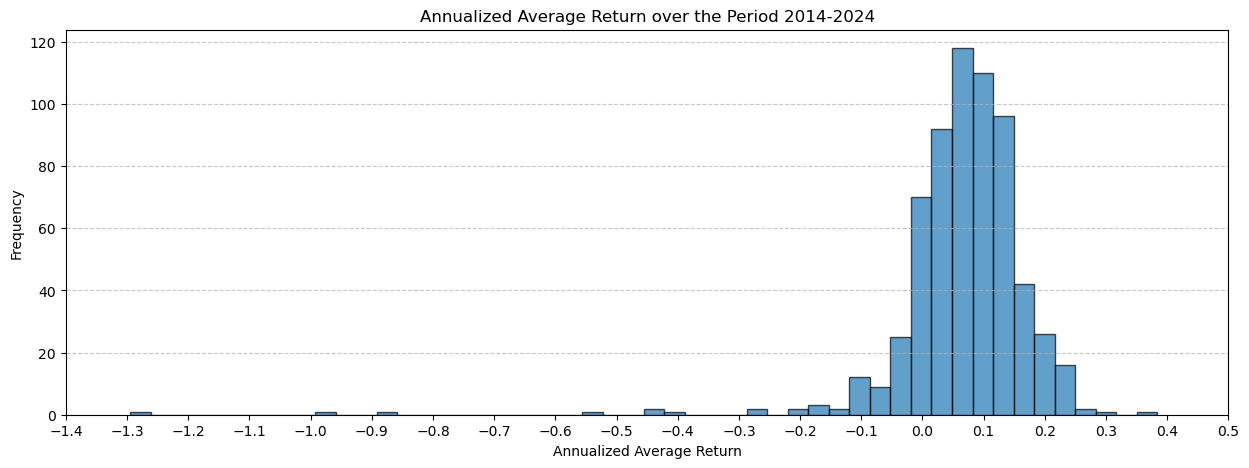

In [19]:
# plot the histogram of annualized average return
plt.figure(figsize = (15, 5))
plt.hist(ann_avg_r, bins=50, edgecolor="black", alpha=0.7)
plt.title("Annualized Average Return over the Period 2014-2024")
plt.xlabel("Annualized Average Return")
plt.ylabel("Frequency")
plt.xticks(np.arange(-1.4, 0.6, step=0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

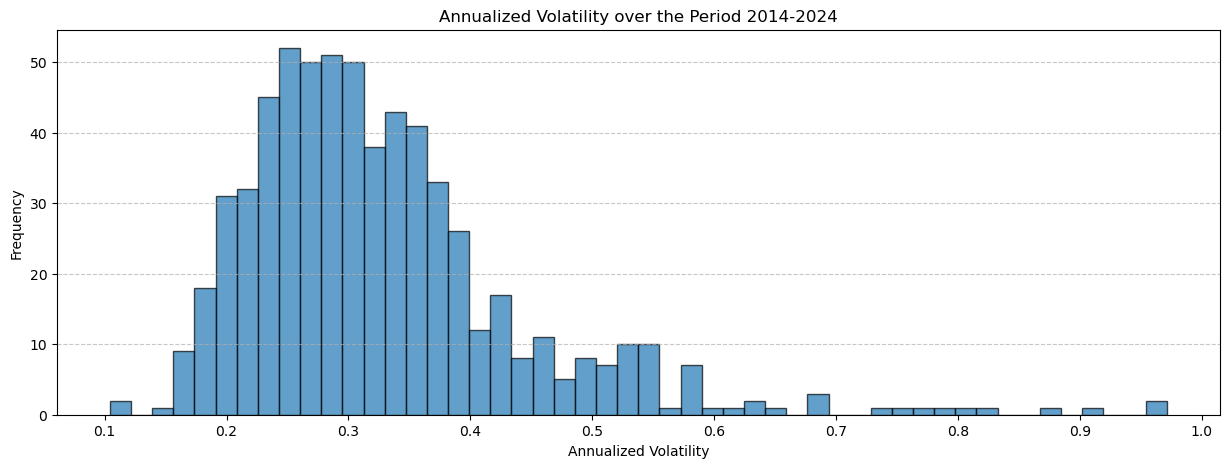

In [20]:
# plot the histogram of annualized volatility
plt.figure(figsize = (15, 5))
plt.hist(ann_vol, bins=50, edgecolor="black", alpha=0.7)
plt.title("Annualized Volatility over the Period 2014-2024")
plt.xlabel("Annualized Volatility")
plt.ylabel("Frequency")
plt.xticks(np.arange(0.1, 1.1, step=0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
# Compute the correlation between individual average return and volatilities in the corss section
df_corr = pd.DataFrame({'ann_avg_r': ann_avg_r, 'ann_vol': ann_vol})
correlation = df_corr.corr().iloc[0, 1]
print(correlation)

-0.3974043643583484


# Q2

## Portfolio 1: Equally weighted portfolio

In [22]:
R_m_p1 = temp3.mean(axis=0)

In [23]:
# annualized average return
# ann_avg_r_p1 = (np.prod(1 + R_m_p1) ** (12 / len(R_m_p1))) - 1 
ann_avg_r_p1 = R_m_p1.mean() * 12
ann_avg_r_p1

0.0651277364571888

In [24]:
# annualized volatility
ann_vol_p1 = R_m_p1.std() * np.sqrt(12)
ann_vol_p1

0.18759061259927418

In [25]:
# Sharpe ratio
R_m_p1 = pd.DataFrame(R_m_p1)
excess_r_p1 = R_m_p1 - RF_m_temp

# vol_p1 = np.std(R_m_p1, axis=0)[0]

# sr_m_p1 = excess_r_p1 / vol_p1 # monthly sharpe ratio

# ann_sr_p1 = sr_m_p1 * np.sqrt(12) # annualized sharpe ratio

ann_sr_p1 = (excess_r_p1.mean() * 12 / (excess_r_p1.std() * np.sqrt(12)))[0]
ann_sr_p1

0.2656242213153573

In [26]:
# minium return & maximum return
R_m_p1_min = R_m_p1.min()[0]
R_m_p1_max = R_m_p1.max()[0]
print(f"Minimum return: {R_m_p1_min}")
print(f"Maximum return: {R_m_p1_max}")

Minimum return: -0.23148306723755774
Maximum return: 0.23229986979698006


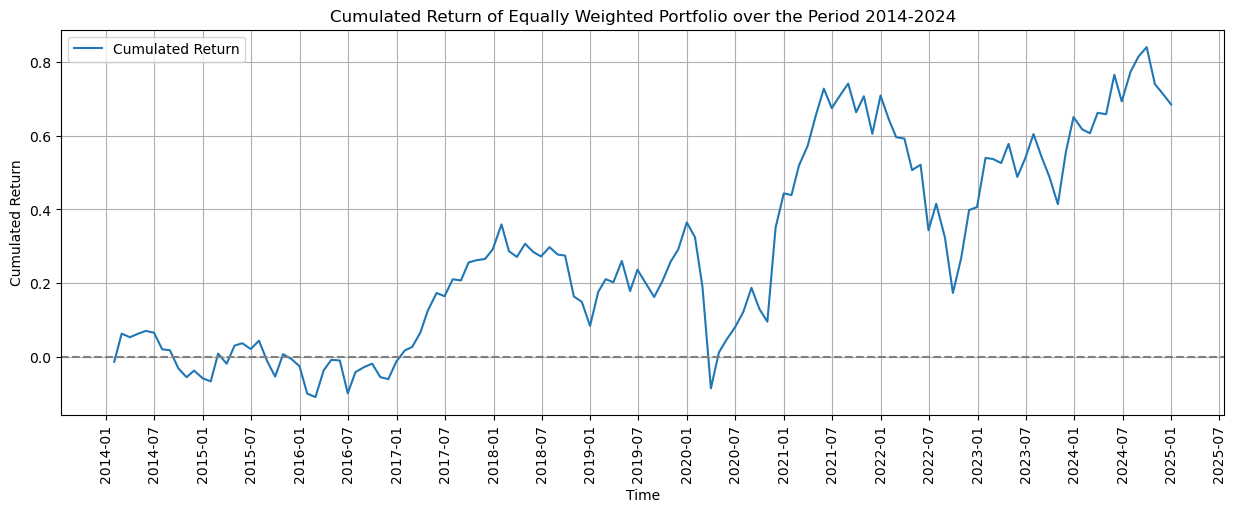

In [27]:
# cumulated returns
cum_r_m_p1 = np.cumprod(1 + R_m_p1) - 1

plt.figure(figsize=(15, 5))
plt.plot(cum_r_m_p1, label="Cumulated Return")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-01-01"))
plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cumulated Return")
plt.title("Cumulated Return of Equally Weighted Portfolio over the Period 2014-2024")
plt.legend()
plt.grid(True)
plt.show()


## Portfolio 2: Market-cap weighted portfolio

In [28]:
mc_weight_p2 = temp3_mc.div(temp3_mc.sum(axis=0), axis=1)
R_m_p2 = (temp3 * mc_weight_p2).sum(axis=0)

In [29]:
# annualized average return
# ann_avg_r_p2 = (np.prod(1 + R_m_p2) ** (12 / len(R_m_p2))) - 1 
ann_avg_r_p2 = R_m_p2.mean() * 12
ann_avg_r_p2

0.10503398643340538

In [30]:
# annualized volatility
ann_vol_p2 = R_m_p2.std() * np.sqrt(12)
ann_vol_p2

0.16024019605276266

In [31]:
# Sharpe ratio
R_m_p2 = pd.DataFrame(R_m_p2)
excess_r_p2 = R_m_p2 - RF_m_temp
# vol_p2 = np.std(R_m_p2, axis=0)[0]
# sr_m_p2 = excess_r_p2 / vol_p2 # monthly sharpe ratio

# ann_sr_p2 = sr_m_p2 * np.sqrt(12) # annualized sharpe ratio

ann_sr_p2 = (excess_r_p2.mean() * 12 / (excess_r_p2.std() * np.sqrt(12)))[0]
ann_sr_p2

0.5604802089115809

In [32]:
# minium return & maximum return
R_m_p2_min = R_m_p2.min()[0]
R_m_p2_max = R_m_p2.max()[0]
print(f"Minimum return: {R_m_p2_min}")
print(f"Maximum return: {R_m_p2_max}")

Minimum return: -0.13213548028959876
Maximum return: 0.19232094721100984


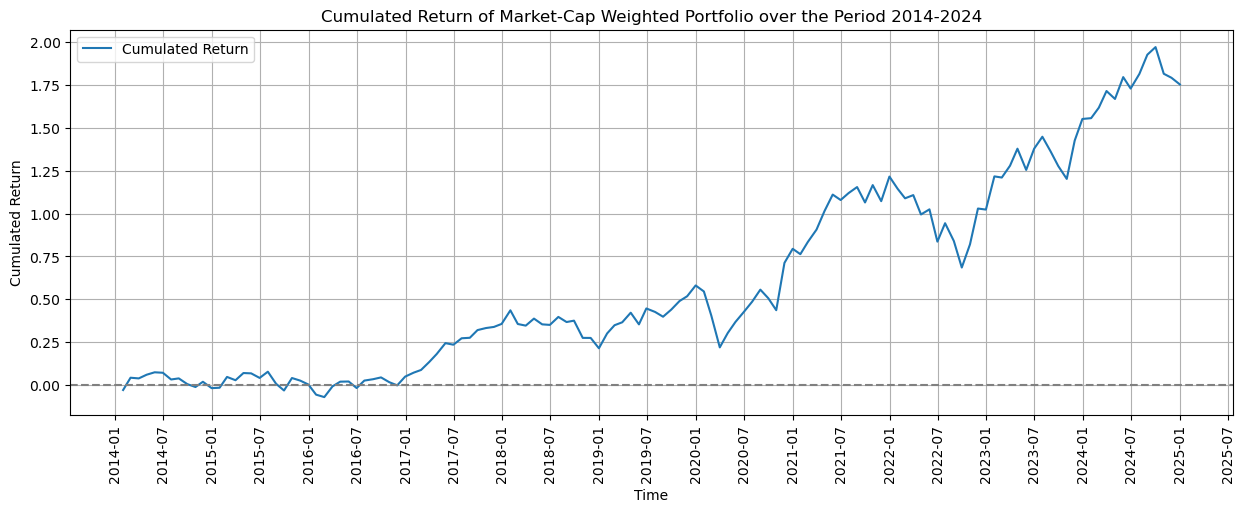

In [33]:
# cumulated returns
cum_r_m_p2 = np.cumprod(1 + R_m_p2) - 1

plt.figure(figsize=(15, 5))
plt.plot(cum_r_m_p2, label="Cumulated Return")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-01-01"))
plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cumulated Return")
plt.title("Cumulated Return of Market-Cap Weighted Portfolio over the Period 2014-2024")
plt.legend()
plt.grid(True)
plt.show()

# Q3

In [34]:
# compute the expected return
expected_r = temp3.mean(axis=1)
ann_expected_r = expected_r.values.reshape((-1, 1)) * 12

In [35]:
# compute the population covariance matrix 
pop_cov = temp3.T.cov(ddof=0)
ann_pop_cov = pop_cov * 12 

# N > T -> correct the non-positive denifite singular matrix
t = temp3.shape[1]
ann_pop_cov_fixed = LedoitWolf().fit(temp3.T).covariance_ * (t-1) / t * 12

In [36]:
# compute the minimum variance portfolio
n = len(temp3)

alpha1 = cp.Variable((n, 1))
objective_min_var = cp.Minimize(cp.quad_form(alpha1, ann_pop_cov_fixed))
constraints_min_var = [cp.sum(alpha1) == 1, alpha1 >= 0]

prob_min_var = cp.Problem(objective_min_var, constraints_min_var)
prob_min_var.solve(solver=cp.GUROBI)

min_var_weights = alpha1.value
min_var_return = np.matmul(min_var_weights.T, ann_expected_r)[0][0]
min_var_return

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2630708
Academic license 2630708 - for non-commercial use only - registered to yo___@epfl.ch


0.020327563608598453

In [37]:
# compute the maximum return portfolio
alpha2 = cp.Variable((n, 1))
objective_max_r = cp.Maximize(cp.matmul(alpha2.T, ann_expected_r))
constraints_max_r = [cp.sum(alpha2) == 1, alpha2 >= 0]

prob_max_r = cp.Problem(objective_max_r, constraints_max_r)
prob_max_r.solve(solver=cp.GUROBI)

max_r_weights = alpha2.value
max_r_return = np.matmul(max_r_weights.T, ann_expected_r)[0][0]
max_r_return

0.3839995896689018

In [38]:
# build the efficient frontier
target_returns = np.linspace(min_var_return, max_r_return, num=20)
efficient_frontier = []

for mu_p in tqdm(target_returns):
    alpha3 = cp.Variable((n, 1))
    objective_ef = cp.Minimize(cp.quad_form(alpha3, ann_pop_cov_fixed))
    constraints_ef = [
        cp.matmul(alpha3.T, ann_expected_r) >= mu_p,
        cp.sum(alpha3) == 1,
        alpha3 >= 0,
    ]
    prob_ef = cp.Problem(objective_ef, constraints_ef)
    prob_ef.solve(solver=cp.GUROBI)

    vol_ef = np.sqrt(alpha3.value.T @ ann_pop_cov @ alpha3.value)
    efficient_frontier.append(
        {"mu": mu_p, "vol": vol_ef[0][0], "weight": alpha3.value.flatten()}
    )

100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


In [39]:
# compute the ex-post performance
weights = [item["weight"] for item in efficient_frontier]
R_m_p3 = []

for weight in weights:
    weight = weight.reshape((1, -1))
    ex_post_r = weight @ temp3.values
    R_m_p3.append(ex_post_r)


In [40]:
# check whether the weights are positive
[np.sum(weight < 0) for weight in weights]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [41]:
# compute the ex-post annualized average return, the ex-post annualized volatility, and the ex-post annualized Sharpe ratio
ann_avg_r_ef_post = []
ann_vol_ef_post = []
ann_sp_ef_post = []

for portfolio in R_m_p3:
    r = portfolio.mean() * 12
    ann_avg_r_ef_post.append(r)
    vol = portfolio.std() * np.sqrt(12)
    ann_vol_ef_post.append(vol)
    e_r = portfolio - RF_m_temp.values
    sp = (e_r.mean() * 12 / (e_r.std() * np.sqrt(12)))
    ann_sp_ef_post.append(sp)

print(f"Ex-post annualized average return: {ann_avg_r_ef_post}")
print(f"Ex-post annualized volatility: {ann_vol_ef_post}")
print(f"Ex-post annualized Sharpe ratio: {ann_sp_ef_post}")


Ex-post annualized average return: [0.020379017821953102, 0.03946819656778837, 0.05860882951149334, 0.07774946248513731, 0.09689009541176803, 0.11603072836623801, 0.1351713613326015, 0.15431199427397155, 0.17345262724084243, 0.19259326023687784, 0.2117338931145623, 0.23087452607448977, 0.2500151590161083, 0.26915579196740597, 0.28829642491666047, 0.3074370578678096, 0.32657769082491495, 0.3457183237675803, 0.36485895673303986, 0.3839995896614653]
Ex-post annualized volatility: [0.0706231471578701, 0.07138203483092487, 0.0736762362534532, 0.07697798468113044, 0.08110997356118796, 0.08610483499846591, 0.09201068086497886, 0.09870480800820991, 0.10630370504038691, 0.11550620864834141, 0.12687618143885038, 0.14128985361514484, 0.15971313413942204, 0.18136777993071918, 0.20706258991639556, 0.23591569221526035, 0.26788961084867774, 0.3037428230800759, 0.34946614490797234, 0.42258061927308255]
Ex-post annualized Sharpe ratio: [0.07209705916691095, 0.338010656308243, 0.5866538963516563, 0.8096

In [42]:
# compute the ex-ante Sharpe ratio
ann_rf = (RF_m_temp.mean() * 12)[0]
ann_sp_ef_ante = []

for item in efficient_frontier:
    mu = item["mu"]
    vol = item["vol"]
    sp_ante = (mu - ann_rf) / vol
    ann_sp_ef_ante.append(sp_ante)

print(f"Ex-ante annualized Sharpe ratio: {ann_sp_ef_ante}")

Ex-ante annualized Sharpe ratio: [0.07157478163032951, 0.33895740495101784, 0.5881964720330647, 0.811618223655742, 1.0062556373103684, 1.1701782030054149, 1.303094737610628, 1.4086372264469869, 1.4879998762048199, 1.5351601871948197, 1.5484479719779478, 1.5259538691228847, 1.4697753757525005, 1.3998245156328308, 1.3185563734796337, 1.238426862793939, 1.1620643389578622, 1.0879124423228739, 1.000343622806986, 0.8725598041634127]


In [43]:
# Compare the performance in terms of ex-ante Sharpe ratio & ex-post Sharpe ratio
print(f"Index of the portfolio with the highest performance in terms of ex-ante Sharpe ratio: {np.argmax(ann_sp_ef_ante)}")
print(f"Index of the portfolio with the highest performance in terms of ex-post Sharpe ratio: {np.argmax(ann_sp_ef_post)}")  


Index of the portfolio with the highest performance in terms of ex-ante Sharpe ratio: 10
Index of the portfolio with the highest performance in terms of ex-post Sharpe ratio: 10


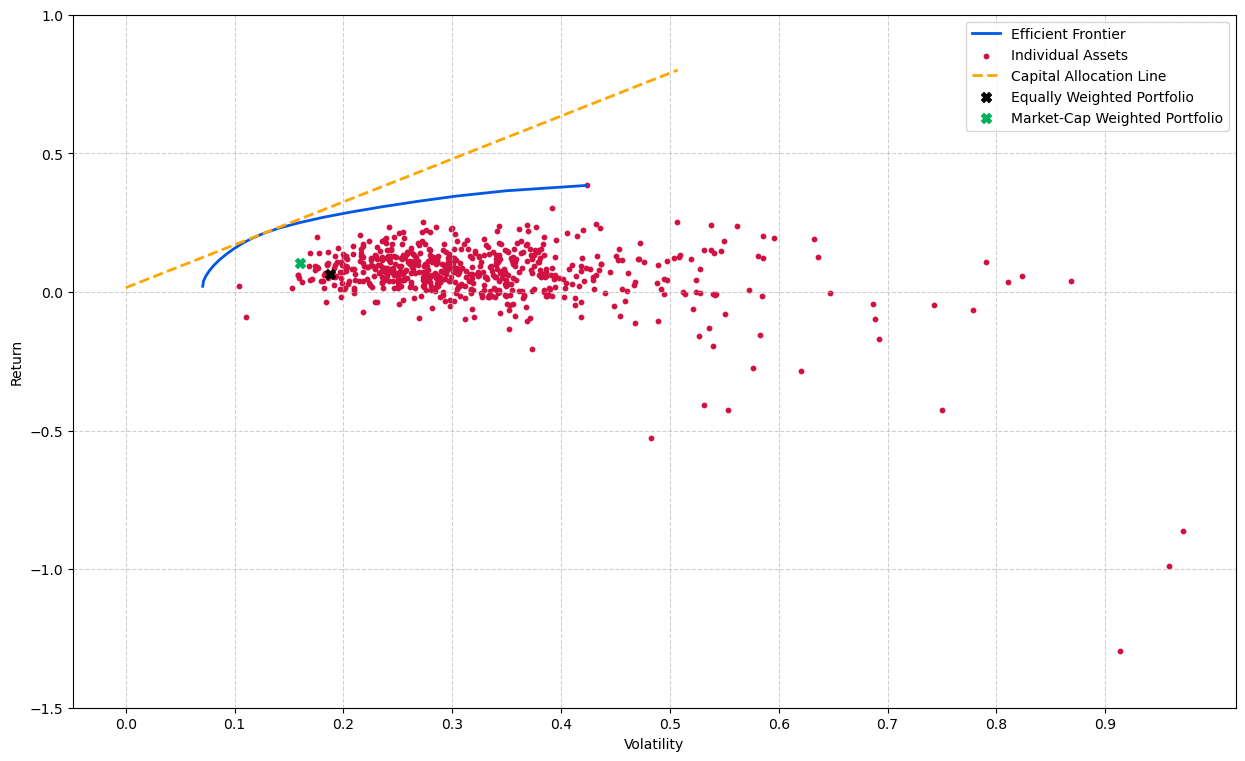

In [44]:
vols = [item["vol"] for item in efficient_frontier]
mus = [item["mu"] for item in efficient_frontier]
cal_slope = np.max(ann_sp_ef_ante)
cal_vol = np.linspace(0, max(vols) * 1.2, 100)
cal_r = ann_rf + cal_slope * cal_vol

plt.figure(figsize=(15, 9))
plt.plot(vols, mus, label="Efficient Frontier", color="#0057e7", linestyle="-", linewidth=2)
plt.scatter(ann_vol, ann_avg_r, color="#d11141", marker="o", label="Individual Assets", s=10)
plt.plot(cal_vol, cal_r, color="orange", linestyle="--", label="Capital Allocation Line", linewidth=2)
plt.scatter(ann_vol_p1, ann_avg_r_p1, color="black", marker="X", s=50, label="Equally Weighted Portfolio")
plt.scatter(ann_vol_p2, ann_avg_r_p2, color="#00b159", marker="X", s=50, label="Market-Cap Weighted Portfolio")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(-1.5, 1.5, step=0.5))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Q4

In [45]:
# compute the expected returns and the covariance matrix (out of sample) for 2014-2024 (yearly)
mu1424 = (temp0424.T.rolling(window=120, step=12).mean() * 12).T #annualized expected return
mu1424 = mu1424.loc[:, mu1424.columns >= pd.Timestamp("2014-01-01")].copy()

tau = 120
step = 12
start_index = [i for i in range(0, 121, 12)]
weights_rw = []
R_m_poos = []

# compute the optimal weight
for start in start_index:
    df = temp0424.iloc[:, start:(start+tau)]
    cov_df = df.T.cov(ddof=0) * 12 # annualized covariance matrix
    cov_df_fixed = LedoitWolf().fit(df.T).covariance_ * (tau - 1) / tau * 12 #fixed annualized covariance matrix

    alpha_df = cp.Variable((n,1))
    objective_rw = cp.Minimize(cp.quad_form(alpha_df, cov_df_fixed))
    constraints_rw = [cp.sum(alpha_df) == 1, alpha_df >= 0]

    prob_rw = cp.Problem(objective_rw, constraints_rw)
    prob_rw.solve(solver=cp.GUROBI)

    alpha_df = alpha_df.value.reshape((1, -1))
    weights_rw.append(alpha_df)

    # compute the portfolio return for the Jan of each year
    r_p_jan = (alpha_df @ temp3.iloc[:, start].values.reshape((-1, 1)))[0][0]
    R_m_poos.append(r_p_jan)

    alpha_df_temp = alpha_df.copy()
    r_p_temp = r_p_jan
    # update the monthly weight
    for i in range(1, 12):
        r = temp3.iloc[:, start+i-1].values.reshape((-1, 1))
        update_coef = ((r + 1) / (1 + r_p_temp)).T  # shape: (1, n)
        alpha_df_temp = alpha_df_temp * update_coef
        weights_rw.append(alpha_df_temp)

        r_p_temp = (alpha_df_temp @ temp3.iloc[:, start+i].values.reshape((-1, 1)))[0][0]
        R_m_poos.append(r_p_temp)


In [46]:
# a time series of ex-post portfolio return
R_m_poos

[-0.01194250208987622,
 0.044732913196638274,
 0.001664948286701582,
 0.0017281810958243396,
 -0.007380284042635576,
 -0.004791435243101215,
 -0.0008853903286354758,
 0.0006482958778216835,
 -0.03964309127280186,
 -0.014918792173927817,
 -0.00640545941098636,
 -0.017578096613665,
 -0.013098503968204377,
 0.07342514719780259,
 -0.02751365109462947,
 0.02199940934026377,
 -0.0009393874402980158,
 -0.008679104628785487,
 0.018090182694128282,
 -0.02403943050970687,
 -0.003966163655525014,
 0.031919362302456275,
 -0.003252120504827514,
 -0.014635328655883201,
 -0.016395216671663534,
 -0.009219367677946897,
 0.023906970106294712,
 0.008331739456144743,
 4.067789080074245e-06,
 -0.0030154685443837346,
 0.016466435138504817,
 -0.007731143160512337,
 0.011270944138845421,
 -0.006045292237188448,
 0.0019111795468896157,
 0.00653401162618978,
 0.003416011031280415,
 0.011609263297462414,
 0.0090059412480646,
 0.0183469797016158,
 0.017748932208665278,
 0.009140492628212971,
 0.01201313347251186,

In [47]:
# Annualized average return
ann_avg_r_poos = np.mean(R_m_poos) * 12
ann_avg_r_poos

0.019043564183184907

In [48]:
# Annualized volatility
ann_vol_poos = np.std(R_m_poos) * np.sqrt(12)
ann_vol_poos

0.09846541188992838

In [49]:
# Sharpe Ratio
R_m_poos = pd.DataFrame(R_m_poos)
R_m_poos.index = RF_m_temp.index
excess_r_poos = R_m_poos - RF_m_temp

ann_sr_poos = (excess_r_poos.mean() * 12 / (excess_r_poos.std() * np.sqrt(12)))[0]
ann_sr_poos

0.038129314377838265

In [50]:
# minimum return & maximum return
R_m_poos_min = R_m_poos.min()[0]
R_m_poos_max = R_m_poos.max()[0]
print(f"Minimum return: {R_m_poos_min}")
print(f"Maximum return: {R_m_poos_max}")

Minimum return: -0.1092807887077533
Maximum return: 0.08984529945122913
